In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
import time

In [2]:
with open('./walk_normal.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    counter = 0
    readings = []
    for row in spamreader:
        keys = [x.split("=")[0] for x in row]
        vals = [float(x.split("=")[1]) for x in row]
        d = dict(zip(keys, vals))
        readings.append(d)


In [3]:
readings

[{'time': 641099.0,
  'accel_x': -0.02,
  'accel_y': 0.13,
  'accel_z': -0.05,
  'gyro_x': -0.01,
  'gyro_y': -0.0,
  'gyro_z': 0.01,
  'mag_x': -45.25,
  'mag_y': -40.38,
  'mag_z': 40.5,
  'orientation_x': 189.25,
  'orientation_y': -108.37},
 {'time': 641110.0,
  'accel_x': 0.0,
  'accel_y': 0.11,
  'accel_z': -0.04,
  'gyro_x': -0.02,
  'gyro_y': -0.01,
  'gyro_z': 0.02,
  'mag_x': -45.25,
  'mag_y': -40.38,
  'mag_z': 40.5,
  'orientation_x': 189.25,
  'orientation_y': -108.37},
 {'time': 641122.0,
  'accel_x': 0.01,
  'accel_y': 0.1,
  'accel_z': -0.04,
  'gyro_x': -0.02,
  'gyro_y': -0.01,
  'gyro_z': 0.02,
  'mag_x': -44.56,
  'mag_y': -39.56,
  'mag_z': 40.06,
  'orientation_x': 189.31,
  'orientation_y': -108.37},
 {'time': 641132.0,
  'accel_x': 0.0,
  'accel_y': 0.13,
  'accel_z': -0.06,
  'gyro_x': -0.01,
  'gyro_y': -0.01,
  'gyro_z': 0.01,
  'mag_x': -44.56,
  'mag_y': -39.56,
  'mag_z': 40.06,
  'orientation_x': 189.31,
  'orientation_y': -108.37},
 {'time': 641143.0,
 

In [4]:
def get_displacement_of_walk_segment(df_data, start_idx, end_idx):
    # first integration
    integral_0 = df_data.accel_z[start_idx:end_idx]

    # first integral
    cumsum = 0
    integral_1 = []
    for idx, elem in enumerate(integral_0):
        delta_time = (df_data.time[start_idx+idx+1] - df_data.time[start_idx+idx] ) / 1000
        cumsum += elem * delta_time
        integral_1.append(cumsum)
    
    # second integral
    cumsum = 0
    integral_2 = []
    for idx, elem in enumerate(integral_1):
        delta_time = (df_data.time[start_idx+idx+1] - df_data.time[start_idx+idx] ) / 1000
        cumsum += elem * delta_time
        integral_2.append(cumsum)
    
    # total_displacement, first_integral, second_integral
    return cumsum, integral_1, integral_2

# total_disp_across_strides = 0
# for (start, end) in strides:
#     total_disp, integral1, integral2 = get_displacement(start, end)
#     print(start, end)
#     print(total_disp)
#     total_disp_across_strides += total_disp
# print("Total Disp:", total_disp_across_strides)

In [6]:
class Stride:
    def __init__(self, df_walk_data, start_idx, stop_idx):
        self.start_idx = start_idx
        self.stop_idx = stop_idx
        self.df_walk_data = df_walk_data

        total_disp, integral1, integral2 = get_displacement_of_walk_segment (df_walk_data, start_idx, stop_idx)
        self.horizontal_length = abs(total_disp)
        self.time_duration = (df_walk_data.time[self.stop_idx] - df_walk_data.time[self.start_idx])/1000
        self.speed = self.horizontal_length/self.time_duration #m/s




In [7]:
segment_length = 100
temp_segment_compute_limit_start = 0
temp_segment_compute_limit_end = 400
# temp_segment_compute_limit_end = len(readings)
total_walk = []
strides = []

# Algorithm Constants
start_quiet_noise_idx = 0
end_quiet_noise_idx = 100 # 1 second sigma calibration
STRIDE_TIMEOUT = 500
num_of_stddev = 3
gaussian_filter_sigma = 5



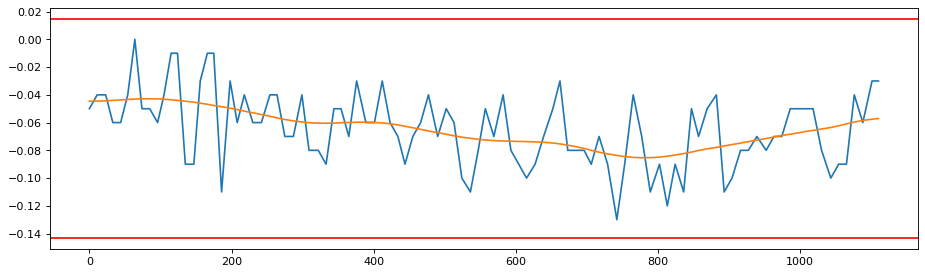

Number of Strides:  0


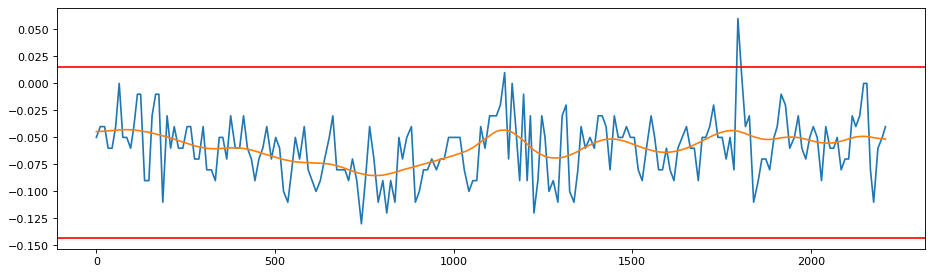

Number of Strides:  0


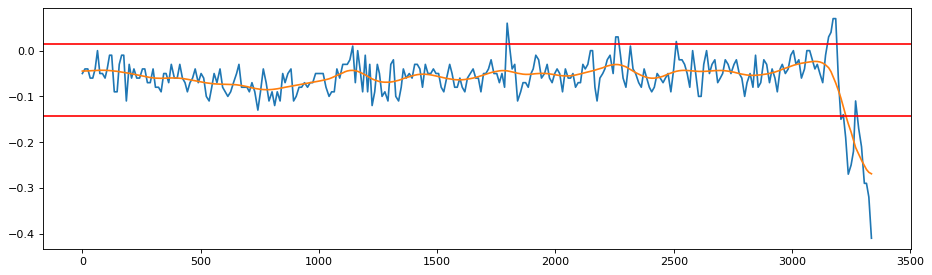

Number of Strides:  0


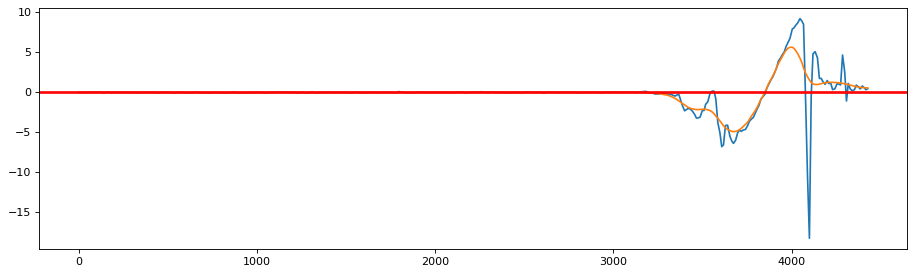

Number of Strides:  0


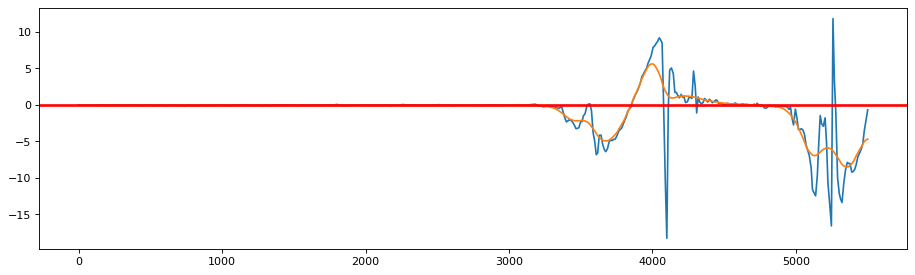

Number of Strides:  1
Stride  0  :
Stride Start Time:  3.227
Stride End Time:  4.678
Stride Length (m): 0.8045655700000003
Stride Time Duration (sec):  1.451
Stride Time Duration (m/s):  0.5544903997243282


In [7]:

for segment_start in np.arange(0,len(readings),segment_length):
    if (segment_start >= temp_segment_compute_limit_start and
        segment_start <= temp_segment_compute_limit_end): # TODO: Remove this IF statment at the end
        
        walk_segment = readings[segment_start:segment_start+segment_length]
        for k in walk_segment: total_walk.append(k) 
        df_walk = pd.DataFrame(total_walk)
        df_walk.time = df_walk.time - df_walk.time[0] # reset time from start of stream

        # Filter out accel_z
        accel_z_smooth = gaussian_filter1d(df_walk.accel_z, gaussian_filter_sigma)

        # Define Baseline Noise

        accel_z_std = np.std(df_walk.accel_z[start_quiet_noise_idx:end_quiet_noise_idx], axis=0)
        accel_z_mean = np.mean(df_walk.accel_z[start_quiet_noise_idx:end_quiet_noise_idx])
        upper_limit = accel_z_mean + num_of_stddev * accel_z_std
        lower_limit = accel_z_mean - num_of_stddev * accel_z_std

        # Determining Stride
        # Stride Class with auto-compute all chracterisitcs
        stride_under = False
        stride_over = False
        start_stride_idx, end_stride_idx = None, None

        for idx, data in enumerate(accel_z_smooth):
            # timeout
            if start_stride_idx and idx-start_stride_idx > STRIDE_TIMEOUT:
                start_stride_idx = None
                stride_under = False
                stride_over = False
            if (data < lower_limit) and (not stride_under and not stride_over):
                # Heal off the ground
                stride_under = True
                start_stride_idx = idx
            elif (data > upper_limit) and (stride_under and not stride_over):
                stride_under = False
                stride_over = True
            elif (data < upper_limit) and (not stride_under and stride_over):
                stride_under = False
                stride_over = False   
                end_stride_idx = idx
                curr_stride = Stride (df_walk, start_stride_idx, end_stride_idx)
                strides.append(curr_stride)

        

        # print ((df_walk.shape))
        fig = plt.figure(figsize=(14, 4), dpi=80)
        plt.plot(df_walk.time,df_walk.accel_z)
        plt.plot(df_walk.time,accel_z_smooth)
        plt.axhline(y=upper_limit, color='r', linestyle='-')
        plt.axhline(y=lower_limit, color='r', linestyle='-')
        plt.show()
        print ("Number of Strides: ", len(strides))
        for idx, stride in enumerate(strides):
            print ("Stride ", idx, " :") 
            print ("Stride Start Time: ", df_walk.time[stride.start_idx]/1000)
            print ("Stride End Time: ", df_walk.time[stride.stop_idx]/1000)
            print ("Stride Length (m):", stride.horizontal_length)
            print ("Stride Time Duration (sec): ", stride.time_duration)
            print ("Stride Time Duration (m/s): ", stride.speed)
        
        time.sleep(1)




In [8]:

x = np.arange(0,len(readings),segment_length)
    

In [9]:
x

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300])

In [ ]:
# Calcualting Normal Vector
import math 
accel_x = [x["accel_x"] for x in readings]
accel_y = [x["accel_y"] for x in readings]
accel_z = [x["accel_z"] for x in readings]
time = [x["time"] for x in readings]
accel_all = []
for i in range(len(accel_x)):
    accel_all.append(math.sqrt(accel_x[i]**2 + accel_y[i]**2 + accel_z[i]**2))

In [ ]:
# Plotting Function
start = 0
end = len(accel_x)-1
x_axis = list(range(start,end))
plt.plot(x_axis, accel_x[start:end]) # blue - vertical elevation - vertical up
plt.plot(x_axis, accel_y[start:end]) # orange - least important - side to side wiggle
plt.plot(x_axis, accel_z[start:end]) # green - most important - forward

In [ ]:
# Adding a Gaussian Filter
from scipy.ndimage import gaussian_filter1d
sigma = 5
# accel_x_smooth = gaussian_filter1d(accel_x, sigma)
# accel_y_smooth = gaussian_filter1d(accel_y, sigma)
# accel_z_smooth = gaussian_filter1d(accel_z, sigma)
# accel_all_smooth = gaussian_filter1d(accel_all, sigma)


start = 400
end = 550
x_axis = list(range(start,end))
accel_z_smooth = gaussian_filter1d(accel_z, sigma)
start_short = 450
end_short = 478
accel_z_short = accel_z[start_short:end_short]
accel_z_smooth_short = gaussian_filter1d(accel_z_short, sigma)
# plt.plot(x_axis,accel_x_smooth[start:end]) # blue - vertical elevation - vertical up
# plt.plot(x_axis, accel_y_smooth[start:end]) # orange - least important - side to side wiggle
# plt.plot(x_axis, accel_z_smooth[start:end]) # green - most important - forward
# plt.plot(x_axis, accel_z[start:end]) # green - most important - forward
fig = plt.figure(figsize=(14, 4), dpi=80)
ax  = fig.add_subplot(1, 1, 1)

plt.plot(x_axis, accel_z_smooth[start:end]) # green - most important - forward
plt.plot(range(start_short,end_short),accel_z_smooth_short) # green - most important - forward
plt.plot(x_axis, accel_z[start:end]) # green - most important - forward



In [ ]:
import numpy as np

start_quiet_noise_idx = 0
end_quiet_noise_idx = 100
num_of_std = 3
accel_z_std = np.std(accel_z[start_quiet_noise_idx:end_quiet_noise_idx], axis=0) # 1 second sigma calibration
accel_z_mean = np.mean(accel_z[start_quiet_noise_idx:end_quiet_noise_idx])
upper = accel_z_mean + num_of_std * accel_z_std
lower = accel_z_mean - num_of_std * accel_z_std
print("Upper Baseline Limit:", upper)
print("Lower Baseline Limit:", lower)

In [ ]:
# fig = plt.figure()
start = 286
end = 363
x_axis = list(range(start,end))
plt.plot(x_axis,accel_z[start:end]) # blue - vertical elevation - vertical up
plt.plot(x_axis, accel_z_smooth[start:end]) # green - most important - forward
plt.axhline(y=upper, color='r', linestyle='-')
plt.axhline(y=lower, color='r', linestyle='-')

In [ ]:
stride_under = False
stride_over = False
TIMEOUT = 500

start_stride, end_stride = None, None

strides = []

for idx, data in enumerate(accel_z_smooth):

  # timeout
  if start_stride and idx-start_stride > TIMEOUT:
    start_stride = None
    stride_under = False
    stride_over = False
  
  if (data < lower) and (not stride_under and not stride_over):
    # Heal off the ground
    stride_under = True
    start_stride = idx
  elif (data > upper) and (stride_under and not stride_over):
    stride_under = False
    stride_over = True
  elif (data < upper) and (not stride_under and stride_over):
    stride_under = False
    stride_over = False   
    end_stride = idx

    strides.append((start_stride, end_stride))

In [ ]:
print(len(time))


In [ ]:
def get_displacement(start, end):
    # first integration
    integral_0 = accel_z[start:end]

    # x_axis = list(range(start,end))
    # plt.plot(x_axis,integral_0) 
    # # print(x_axis)
    

    # m = (integral_0[-1] - integral_0[0])/(end-start) 
    # print ("m=", m)
    # b = integral_0[0]
    # print ("b=", b)
    # print ("before accel:", integral_0)
    # print(m, b)
    # new_x = list(range(len(x_axis)))
    # new_y = [a*m+b for a in new_x]
    # plt.plot(x_axis,new_y)
    # integral_0 = np.array(integral_0) - np.array(new_y)
    # plt.plot(x_axis, integral_0)

    # for idx,val in enumerate(integral_0):
    #     # print ("before")
    #     integral_0[idx] = val - (m*(idx+start)+b)
    # print ("after accel:", integral_0)


    # first integral
    cumsum = 0
    integral_1 = []
    for idx, elem in enumerate(integral_0):
        delta_time = (time[start+idx+1] - time[start+idx] ) / 1000
        cumsum += elem * delta_time
        integral_1.append(cumsum)
    
    # second integral
    cumsum = 0
    integral_2 = []
    for idx, elem in enumerate(integral_1):
        delta_time = (time[start+idx+1] - time[start+idx] ) / 1000
        cumsum += elem * delta_time
        integral_2.append(cumsum)
    
    # total_displacement, first_integral, second_integral
    return cumsum, integral_1, integral_2

total_disp_across_strides = 0
for (start, end) in strides:
    total_disp, integral1, integral2 = get_displacement(start, end)
    print(start, end)
    print(total_disp)
    total_disp_across_strides += total_disp
print("Total Disp:", total_disp_across_strides)

In [ ]:
total_disp, vel_arr, disp_arr = get_displacement(0, len(accel_z)-1)

In [ ]:
start = 0
end = len(vel_arr)-1
x_axis = list(range(start,end))
plt.plot(x_axis,vel_arr[start:end]) 

In [ ]:
start = 0
end = len(disp_arr)-1
x_axis = list(range(start,end))
plt.plot(x_axis,disp_arr[start:end]) 

In [ ]:
strides

In [ ]:
class Stride(NamedTuple):
    start_time: int
    end_time: int


In [ ]:
plt.plot(accel_all_smooth)

In [ ]:
filter = [1,4,9,4,1]
num_starts = len(accel_x)-len(filter) + 1

smooth = []
for i in range(num_starts):
    sum = 0
    for j in range(len(filter)):
        sum += filter[j] * accel[i+j]
    smooth.append(sum)



In [ ]:
plt.plot(accel_x)
plt.plot(smooth[400:500])

In [ ]:
plt.plot(accel[400:500])

In [ ]:
plt.plot(accel_x[400:500])
plt.plot(accel_y[400:500])
plt.plot(accel_z[400:500])

In [ ]:
# def gkern(l=5, sig=1.):
#     """\
#     creates gaussian kernel with side length `l` and a sigma of `sig`
#     """
#     ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
#     gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
#     kernel = np.outer(gauss, gauss)
#     return kernel / np.sum(kernel)
# print(gkern(5))

from scipy.ndimage import gaussian_filter1d
filter = gaussian_filter1d([1.0, 2.0, 3.0, 4.0, 5.0], 1)

In [ ]:
print()

In [ ]:
plt.plot([7,2,3,4,5])

In [ ]:
len(gyro_x)
# for i, data in enumerate(accel_x):
#     print(data)

In [ ]:
# import pandas as pd


# df = pd.read_csv("/walk_normal.csv")